In [11]:
import pandas as pd

# Load the dataset
df = pd.read_csv('dataset.csv')

# Show column names to see what’s available
print(df.columns.tolist())

# Show first few rows of the dataset
print(df.head())


['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude', 'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength', 'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime']
   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy VehicleType  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61         car   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64         car   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80         car   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107         car   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150        bike   

  TrafficConditionNearby  QueueLength  IsSpecialDay LastUpdatedDate  \
0                    low            1             0      04-10-2016   
1                    low            1             0      04-10-2016   
2                    low            2             0      04-10-2016   
3                    low            2     

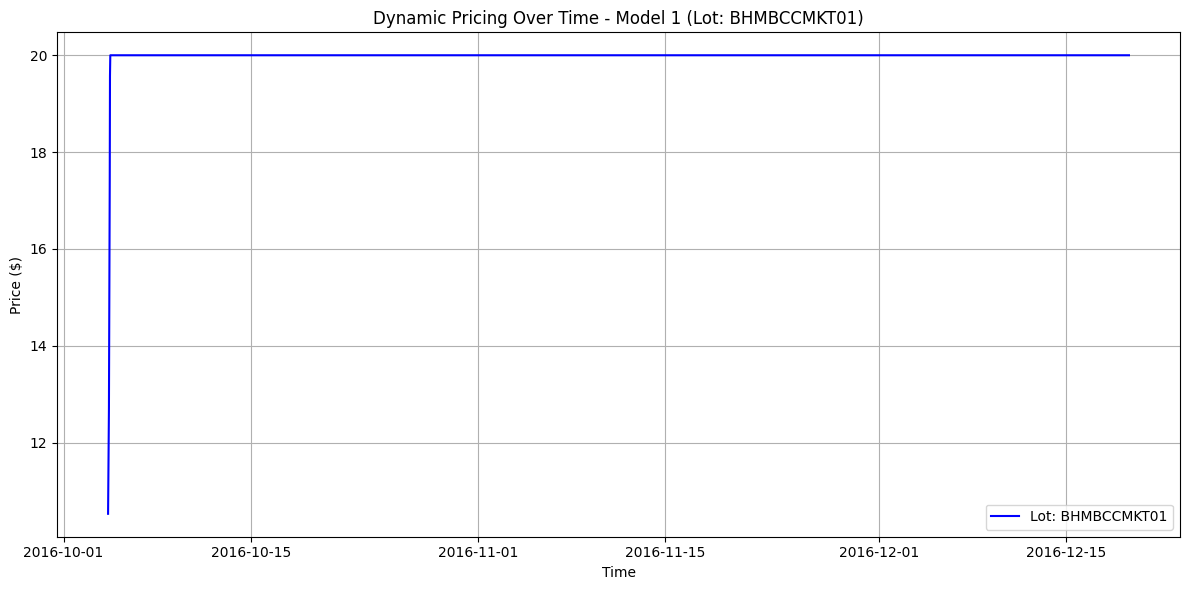

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess
df = pd.read_csv('dataset.csv')

# Combine date and time to create a timestamp
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')

# Sort by timestamp per parking lot
df = df.sort_values(by=['SystemCodeNumber', 'Timestamp'])

# Set parameters
base_price = 10
alpha = 5
min_price = 5
max_price = 20

# Initialize price column
df['Price'] = np.nan

# Apply pricing model per parking lot
for lot, group in df.groupby('SystemCodeNumber'):
    price_list = []
    prev_price = base_price
    for _, row in group.iterrows():
        occ_rate = row['Occupancy'] / row['Capacity']
        new_price = prev_price + alpha * occ_rate
        # Clamp the price
        new_price = max(min_price, min(max_price, new_price))
        price_list.append(new_price)
        prev_price = new_price
    
    df.loc[group.index, 'Price'] = price_list

# Plot example for one lot
sample_lot = df['SystemCodeNumber'].unique()[0]
sample_df = df[df['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(12, 6))
plt.plot(sample_df['Timestamp'], sample_df['Price'], label=f'Lot: {sample_lot}', color='blue')
plt.title(f'Dynamic Pricing Over Time - Model 1 (Lot: {sample_lot})')
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


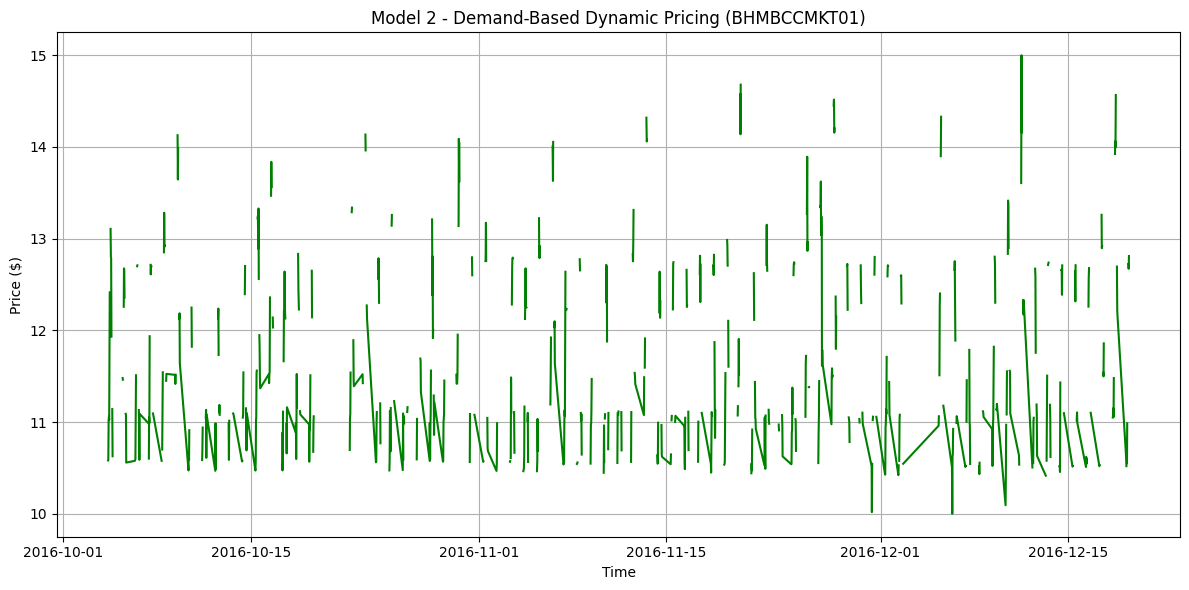

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reload data
df = pd.read_csv('dataset.csv')
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')
df = df.sort_values(by=['SystemCodeNumber', 'Timestamp'])

# Encode Traffic
traffic_map = {'low': 1, 'medium': 2, 'high': 3}
df['TrafficEncoded'] = df['TrafficConditionNearby'].map(traffic_map)

# Encode Vehicle Type
vehicle_map = {'bike': 0.7, 'car': 1.0, 'truck': 1.3}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_map)

# Normalize Occupancy Rate
df['OccRate'] = df['Occupancy'] / df['Capacity']

# Demand Function Parameters
alpha = 3.0     # for occupancy
beta = 1.5      # for queue
gamma = 1.0     # for traffic
delta = 2.0     # for special day
epsilon = 1.2   # for vehicle type
lambda_ = 0.5   # scale for price
base_price = 10

# Calculate Raw Demand
df['RawDemand'] = (alpha * df['OccRate'] +
                   beta * df['QueueLength'] -
                   gamma * df['TrafficEncoded'] +
                   delta * df['IsSpecialDay'] +
                   epsilon * df['VehicleWeight'])

# Normalize Demand per parking lot
df['NormalizedDemand'] = df.groupby('SystemCodeNumber')['RawDemand'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-5)
)

# Calculate Price
df['Price'] = base_price * (1 + lambda_ * df['NormalizedDemand'])

# Clamp price
df['Price'] = df['Price'].clip(lower=5, upper=20)

# Plot for one lot
sample_lot = df['SystemCodeNumber'].unique()[0]
sample_df = df[df['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(12, 6))
plt.plot(sample_df['Timestamp'], sample_df['Price'], color='green')
plt.title(f'Model 2 - Demand-Based Dynamic Pricing ({sample_lot})')
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km radius of Earth
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    return R * 2 * asin(sqrt(a))


In [15]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt

# Reload Data
df = pd.read_csv('dataset.csv')
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')
df = df.sort_values(by=['SystemCodeNumber', 'Timestamp'])

# Encode features (same as Model 2)
df['TrafficEncoded'] = df['TrafficConditionNearby'].map({'low': 1, 'medium': 2, 'high': 3})
df['VehicleWeight'] = df['VehicleType'].map({'bike': 0.7, 'car': 1.0, 'truck': 1.3})
df['OccRate'] = df['Occupancy'] / df['Capacity']

# Demand function
α, β, γ, δ, ε, λ = 3.0, 1.5, 1.0, 2.0, 1.2, 0.5
base_price = 10

df['RawDemand'] = (α * df['OccRate'] +
                   β * df['QueueLength'] -
                   γ * df['TrafficEncoded'] +
                   δ * df['IsSpecialDay'] +
                   ε * df['VehicleWeight'])

df['NormalizedDemand'] = df.groupby('SystemCodeNumber')['RawDemand'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-5)
)

# Base price without competition
df['InitialPrice'] = base_price * (1 + λ * df['NormalizedDemand'])

# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

# Compute lot locations
lot_locations = df.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first().to_dict('index')

# Apply competitive pricing
final_prices = []
for idx, row in df.iterrows():
    my_lat = row['Latitude']
    my_lon = row['Longitude']
    my_lot = row['SystemCodeNumber']
    my_price = row['InitialPrice']
    my_timestamp = row['Timestamp']

    # Find nearby lots within 0.5 km
    competitors = []
    for lot_id, loc in lot_locations.items():
        if lot_id == my_lot:
            continue
        dist = haversine(my_lat, my_lon, loc['Latitude'], loc['Longitude'])
        if dist < 0.5:
            competitors.append(lot_id)

    # Find competitor prices at the same timestamp
    comp_prices = df[(df['SystemCodeNumber'].isin(competitors)) & (df['Timestamp'] == my_timestamp)]['InitialPrice']
    if not comp_prices.empty:
        avg_comp_price = comp_prices.mean()
        if my_price > avg_comp_price:
            adjusted_price = my_price - 1  # decrease to stay competitive
        elif my_price < avg_comp_price:
            adjusted_price = my_price + 0.5  # slight increase is okay
        else:
            adjusted_price = my_price
    else:
        adjusted_price = my_price  # no competitors found

    # Clamp
    adjusted_price = min(20, max(5, adjusted_price))
    final_prices.append(adjusted_price)

df['FinalPrice'] = final_prices


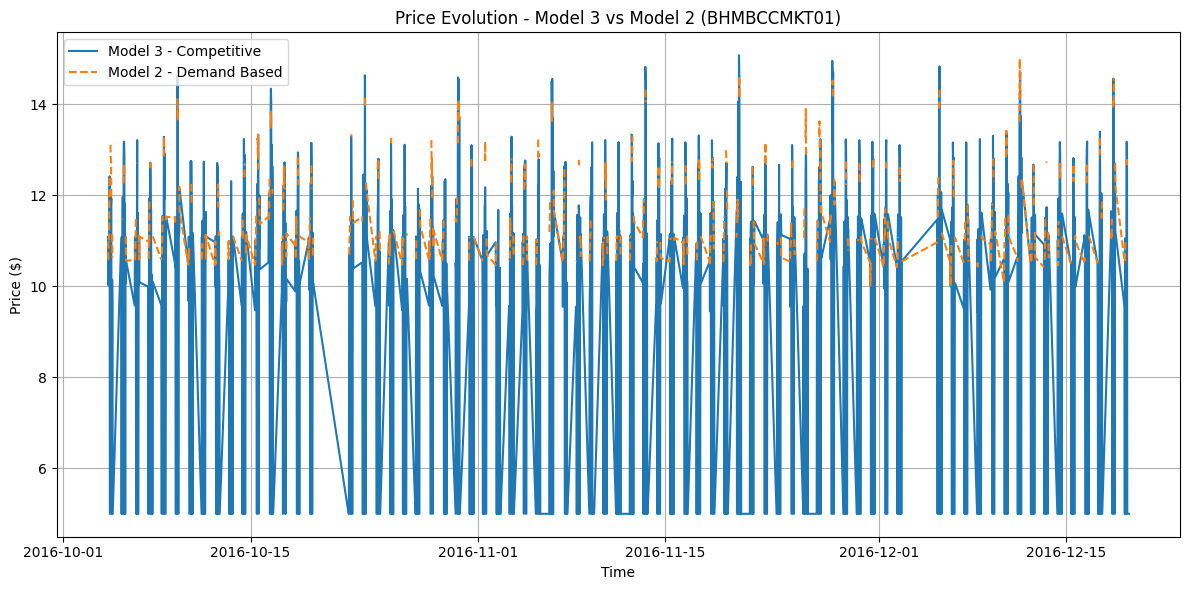

In [16]:
import matplotlib.pyplot as plt

sample_lot = df['SystemCodeNumber'].unique()[0]
sample_df = df[df['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(12, 6))
plt.plot(sample_df['Timestamp'], sample_df['FinalPrice'], label='Model 3 - Competitive')
plt.plot(sample_df['Timestamp'], sample_df['InitialPrice'], label='Model 2 - Demand Based', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.title(f'Price Evolution - Model 3 vs Model 2 ({sample_lot})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
# Simulate for first 50 rows
print(f"{'Timestamp':<20} {'Lot':<14} {'Price ($)':<10}")
print("=" * 45)

for _, row in df.head(50).iterrows():
    price = compute_price(row['OccRate'], row['QueueLength'], row['TrafficEncoded'],
                          row['IsSpecialDay'], row['VehicleWeight'])
    
    print(f"{str(row['Timestamp'])[:19]:<20} {row['SystemCodeNumber']:<14} {price:<10}")
    time.sleep(0.1)  # Simulate real-time delay


Timestamp            Lot            Price ($) 
2016-10-04 07:59:00  BHMBCCMKT01    11.01     
2016-10-04 08:25:00  BHMBCCMKT01    11.02     
2016-10-04 08:59:00  BHMBCCMKT01    11.81     
2016-10-04 09:32:00  BHMBCCMKT01    11.88     
2016-10-04 09:59:00  BHMBCCMKT01    11.81     
2016-10-04 10:26:00  BHMBCCMKT01    12.81     
2016-10-04 10:59:00  BHMBCCMKT01    14.35     
2016-10-04 11:25:00  BHMBCCMKT01    5         
2016-10-04 11:59:00  BHMBCCMKT01    5         
2016-10-04 12:29:00  BHMBCCMKT01    15.61     
2016-10-04 13:02:00  BHMBCCMKT01    15.05     
2016-10-04 13:29:00  BHMBCCMKT01    15.03     
2016-10-04 14:02:00  BHMBCCMKT01    13.47     
2016-10-04 14:29:00  BHMBCCMKT01    5         
2016-10-04 14:57:00  BHMBCCMKT01    5         
2016-10-04 15:30:00  BHMBCCMKT01    12.03     
2016-10-04 16:04:00  BHMBCCMKT01    11.09     
2016-10-04 16:31:00  BHMBCCMKT01    5         
2016-10-05 07:57:00  BHMBCCMKT01    10.99     
2016-10-05 08:30:00  BHMBCCMKT01    5         
2016-10-05 09

In [18]:
!pip install bokeh


In [19]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()


Loading BokehJS ...

In [20]:
import pandas as pd
import numpy as np
import time
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook

output_notebook()


Loading BokehJS ...

In [21]:
df = pd.read_csv("dataset.csv")

# Merge timestamp
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')
df = df.sort_values(by='Timestamp')

# Encode categorical features
traffic_map = {'low': 1, 'medium': 2, 'high': 3}
vehicle_map = {'bike': 0.7, 'car': 1.0, 'truck': 1.3}

df['TrafficEncoded'] = df['TrafficConditionNearby'].map(traffic_map)
df['VehicleWeight'] = df['VehicleType'].map(vehicle_map)
df['OccRate'] = df['Occupancy'] / df['Capacity']


In [22]:
def compute_price(occ_rate, queue_len, traffic_level, special_day, vehicle_weight):
    alpha = 3
    beta = 1.5
    gamma = 1
    delta = 2
    epsilon = 1.2
    lambda_ = 0.5
    base_price = 10

    demand = (alpha * occ_rate +
              beta * queue_len -
              gamma * traffic_level +
              delta * special_day +
              epsilon * vehicle_weight)
    
    norm_demand = demand / 10  # rough normalization
    price = base_price * (1 + lambda_ * norm_demand)
    return round(min(20, max(5, price)), 2)  # clamp price between 5 and 20


In [23]:
# Use first parking lot as sample
sample_lot = df['SystemCodeNumber'].unique()[0]
sample_df = df[df['SystemCodeNumber'] == sample_lot].head(50)

source = ColumnDataSource(data=dict(time=[], price=[]))

p = figure(title=f"Live Dynamic Pricing - {sample_lot}",
           x_axis_type='datetime',
           width=800, height=400)
p.line(x='time', y='price', source=source, line_width=2, color='navy')
p.circle(x='time', y='price', source=source, size=6, color='orange')
p.xaxis.axis_label = 'Timestamp'
p.yaxis.axis_label = 'Price ($)'

handle = show(p, notebook_handle=True)

# Stream data row-by-row like a real-time feed
for _, row in sample_df.iterrows():
    price = compute_price(row['OccRate'], row['QueueLength'], row['TrafficEncoded'],
                          row['IsSpecialDay'], row['VehicleWeight'])

    new_data = {
        'time': [row['Timestamp']],
        'price': [price]
    }

    source.stream(new_data, rollover=100)
    push_notebook(handle=handle)
    time.sleep(0.3)  # simulate 0.3 second delay
